<a id='top'></a>

<a href='#rdd'>RDD</a> | <a href='#mr'>MapReduce</a> | <a href='#df'>SQL and DataFrames</a>  | <a href='#log'>Logistic Regression</a> | <a href='#lin'>Linear Regression</a>
<br>

---

# SPARK with Python
Apache Spark partitions data and computations over a cluster with multiple nodes (consider each node a separate computer). This makes it easier to work with very large datasets because each node only works with a small amount of data.

As each node operates on a subset of the data, it also performs part of the calculations required, so that both data processing and computation are performed in parallel over the nodes in a cluster.

* Install Apache Spark:
```
brew install apache-spark
```
* Confirm that Java SDK 1.8+ is installed.


* To use in notebook:
```
pip install findspark
```

---
From the Apache Spark 2.3.1 [Quick Start Guide](https://spark.apache.org/docs/2.3.1/quick-start.html):
>Note that, before Spark 2.0, the main programming interface of Spark was the Resilient Distributed Dataset (RDD). After Spark 2.0, RDDs are replaced by Dataset (DataFrame), which is strongly-typed like an RDD, but with richer optimizations under the hood. The RDD interface is still [supported](https://spark.apache.org/docs/2.3.1/rdd-programming-guide.html). 

DataFrame has better performance than RDD.

---
## PYSPARK
[PySpark](https://spark.apache.org/docs/2.3.1/api/python/index.html) is the Python API for Spark. Core classes include:

`pyspark.SparkContext`

* Main entry point for Spark functionality.

`pyspark.RDD`

* A Resilient Distributed Dataset (RDD), the basic abstraction in Spark.

`pyspark.streaming.StreamingContext`

* Main entry point for Spark Streaming functionality.

`pyspark.streaming.DStream`

* A Discretized Stream (DStream), the basic abstraction in Spark Streaming.

`pyspark.sql.SQLContext`

* Main entry point for DataFrame and SQL functionality.

`pyspark.sql.DataFrame`

* A distributed collection of data grouped into named columns.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import findspark
findspark.init()
import pyspark

from pyspark import SparkContext, SparkConf

%matplotlib inline
sns.set_style('whitegrid')
sns.set_context("poster")

pd.options.display.max_columns = 310

## Initialize Spark

The first step for a Spark program is to access a cluster by creating a `SparkContext` object. The class constructor takes a few optional arguments that specify information about the application. A `SparkConf` object holds these attributes:
```python
conf = SparkConf().setAppName(appName).setMaster(master)
sc = SparkContext(conf=conf)
```
The `appName` parameter is the name to show on the cluster UI. The `master` parameter specifies the remote or local machine that is connected to all other nodes. If the `SparkConf` object is not instantiated, defaults are implicit.

In [2]:
sc = SparkContext()
sc

<SparkContext master=local[*] appName=pyspark-shell>

<a href='#top' id='rdd'>back to menu</a>

---
## RESILIENT DISTRIBUTED DATASET (RDD)
Spark's core data structure is the [Resilient Distributed Dataset (RDD)](http://spark.apache.org/docs/2.1.0/api/python/pyspark.html#pyspark.RDD). RDDs are created by parallelizing an existing collection or referencing an external dataset.

## Parallelizing
Parallelized collections are created by calling the `SparkContext` `parallelize` method on an existing iterable or collection:
```python
data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
rdd = sc.parallelize(data)
```
Spark will run one task for each partition of the cluster. The recommendation is 2-4 partitions for each CPU in the cluster which Spark tries to set automatically based on the cluster. However, the number of partitions can be set manually by passing it as a second parameter to parallelize: `sc.parallelize(data, 5)`.

In [3]:
# Once created, the rdd can be operated on in parallel:
sc.parallelize([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]).map(lambda x: x**2).sum()

385

## External Data
External data collections are created by calling the `SparkContext` `textFile()` method on a URI for the file:
```python
rdd = sc.textFile('data.txt')
```

In [4]:
# Once created, the rdd can be acted on by dataset operations:
sc.textFile('data/shakespeare/asyoulikeit.txt').map(lambda s: len(s)).sum()

133893

## Operations & Functions
RDDs support two types of operations:
* [Transformations](https://spark.apache.org/docs/2.3.1/rdd-programming-guide.html#transformations) - create a new dataset from an existing one.


* [Actions](https://spark.apache.org/docs/2.3.1/rdd-programming-guide.html#actions) - return a value after running a computation on the dataset. 


Transformations in Spark are considered lazy because the results are not computed immediately. Instead, the transformations are applied only when an action is required to return a result, enabling Spark to run more efficiently.

In [5]:
mammals = ['rat', 'elephant', 'cat', 'rat', 'cat']
rdd = sc.parallelize(mammals)
print(type(rdd))
rdd

<class 'pyspark.rdd.RDD'>


ParallelCollectionRDD[5] at parallelize at PythonRDD.scala:184

In [6]:
rdd.collect()

['rat', 'elephant', 'cat', 'rat', 'cat']

In [7]:
def make_plural(word):
    return word + 's'

print(make_plural('dog'))
print()

# transform the dataset, creating a new one:
plural_words = rdd.map(make_plural)

# view the results of some actions:
print(plural_words.first())
print(plural_words.take(2))
print(plural_words.collect())

dogs

rats
['rats', 'elephants']
['rats', 'elephants', 'cats', 'rats', 'cats']


## Key-Value Pairs and MapReduce
Some operations, such as those that group or aggregate, can occur only on RDD objects made up of key-value pairs. For example, the `reduceByKey` operation counts the number of times each key occurs in the RDD.

This is central to the MapReduce algorithm for returning the results of computations across very large datasets. 

* Map is a transformation that partitions the dataset and passes each element through a function which returns a new RDD of the results as tuples in key-value pairs.


* Reduce is an action that first groups elements by key, then applies a function to aggregate all elements returning the result only, sometimes as a distributed dataset (Reduce by Key).

In [8]:
rdd.map(lambda s: len(s))

PythonRDD[9] at RDD at PythonRDD.scala:49

In [9]:
rdd.reduce(lambda a, b: a + b)

'ratelephantcatratcat'

In [10]:
rdd.map(lambda s: len(s)).collect()

[3, 8, 3, 3, 3]

In [11]:
rdd.map(lambda s: len(s)).reduce(lambda a, b: a + b)

20

In [12]:
rdd.map(lambda s: len(s)).sum()

20

From the Spark [RDD Programming Guide](https://spark.apache.org/docs/2.3.1/rdd-programming-guide.html#shuffle-operations):
>Certain operations within Spark trigger an event known as the shuffle. The shuffle is Spark’s mechanism for re-distributing data so that it’s grouped differently across partitions. This typically involves copying data across executors and machines, making the shuffle a complex and costly operation.

The `reduceByKey` operation is an example of this.


## Reduce by Key
The diagram below illustrates `reduceByKey` very clearly! (Kudos and gratitude to the author.)

![](http://people.revoledu.com/kardi/tutorial/DataScience/Image/mapreduce_example.png)

(image credit: http://people.revoledu.com/kardi/tutorial/DataScience/Image/mapreduce_example.png)

In [13]:
word_pairs = rdd.map(lambda w: (w, 1))
print(word_pairs)

PythonRDD[14] at RDD at PythonRDD.scala:49


In [14]:
# ok, lazy, now print the pairs:
print(word_pairs.collect())

[('rat', 1), ('elephant', 1), ('cat', 1), ('rat', 1), ('cat', 1)]


In [15]:
print(word_pairs.reduceByKey(lambda a, b: a + b))

PythonRDD[19] at RDD at PythonRDD.scala:49


In [16]:
# ok, lazy, now print the word counts:
print(word_pairs.reduceByKey(lambda a, b: a + b).collect())

[('cat', 2), ('rat', 2), ('elephant', 1)]


In [17]:
# chain all operations, including sort:
rdd.map(lambda w: (w, 1)).reduceByKey(lambda x,y: x+y).sortByKey().collect()

[('cat', 2), ('elephant', 1), ('rat', 2)]

## Persist (Cache) the RDD
By default, each transformed RDD may be recomputed each time an action is run. Persisting an RDD in memory allows Spark to keep computed elements on the cluster for faster access the next time it is queried. 

* The first time a persisted RDD is computed in an action, it will be kept in memory on the nodes at the desired [storage level](https://spark.apache.org/docs/2.3.1/rdd-programming-guide.html#rdd-persistence), set by passing a `StorageLevel` object to `persist()`. 


* The `cache()` method applies the default, `StorageLevel.MEMORY_ONLY`.


Caching is particularly useful for iterative algorithms:

In [18]:
birds = ['heron','owl']
animals = mammals + birds
animal_dictionary = {}

for m in mammals:
    animal_dictionary[m] = 'mammal'
for b in birds:
    animal_dictionary[b] = 'bird'
    
animal_dictionary

{'cat': 'mammal',
 'elephant': 'mammal',
 'heron': 'bird',
 'owl': 'bird',
 'rat': 'mammal'}

In [19]:
animal_rdd = sc.parallelize(animals)
animal_rdd.cache()

mammal_count = animal_rdd.filter(lambda w: animal_dictionary[w]=='mammal').count()
bird_count = animal_rdd.filter(lambda w: animal_dictionary[w]=='bird').count()

print('bird count: {}, mammal count: {}'.format(bird_count, mammal_count))

bird count: 2, mammal count: 5


<a href='#top' id='mr'>back to menu</a>

---
## MAP REDUCE SHAKESPEARE



The text file `english_stop.txt` contains a list of English stopwords, while the following files contain the text of some of Shakespeare's plays:
```
asyoulikeit.txt
coriolanus.txt
hamlet.txt
juliuscaesar.txt
kinglear.txt
kingrichard3.txt
macbeth.txt
measureformeasure.txt
merchantofvenice.txt
midsummersnightdream.txt
othello.txt
romeojuliet.txt
tamingshrew.txt
titusandronicus.txt
twelfthnight.txt
```

In [20]:
stop_words = sc.textFile('data/english_stop.txt').collect()
type(stop_words)

list

In [21]:
jc_rdd = sc.textFile('data/shakespeare/juliuscaesar.txt')
type(jc_rdd)

pyspark.rdd.RDD

In [22]:
import re

jc_words = jc_rdd.flatMap(lambda w: w.split(' ')) \
    .map(lambda w: re.sub(r"[^a-zA-Z']", '', w)) \
    .map(lambda w: w.lower()) \
    .filter(lambda w: w != '')
    
print('Number of words in Julius Caesar:', len(jc_words.collect()))

Number of words in Julius Caesar: 21185


In [23]:
print('The first 20 words of Julius Caesar:')
jc_words.collect()[:20]

The first 20 words of Julius Caesar:


['the',
 'tragedy',
 'of',
 'julius',
 'caesar',
 'by',
 'william',
 'shakespeare',
 'dramatis',
 'personae',
 'julius',
 'caesar',
 'roman',
 'statesman',
 'and',
 'general',
 'octavius',
 'triumvir',
 'after',
 "caesar's"]

In [24]:
print('The first 20 words of Julius Caesar minus stop words:')
jc_words.filter(lambda w: w not in stop_words).collect()[:20]

The first 20 words of Julius Caesar minus stop words:


['tragedy',
 'julius',
 'caesar',
 'william',
 'shakespeare',
 'dramatis',
 'personae',
 'julius',
 'caesar',
 'roman',
 'statesman',
 'general',
 'octavius',
 'triumvir',
 "caesar's",
 'death',
 'augustus',
 'caesar',
 'emperor',
 'rome']

In [25]:
# MapReduce:
jc_word_counts = jc_words.filter(lambda w: w not in stop_words).map(lambda w: (w, 1)).reduceByKey(lambda x,y: x+y)

# Top 20 word counts:
top20_jc_words = jc_word_counts.takeOrdered(20, lambda e: -e[1])

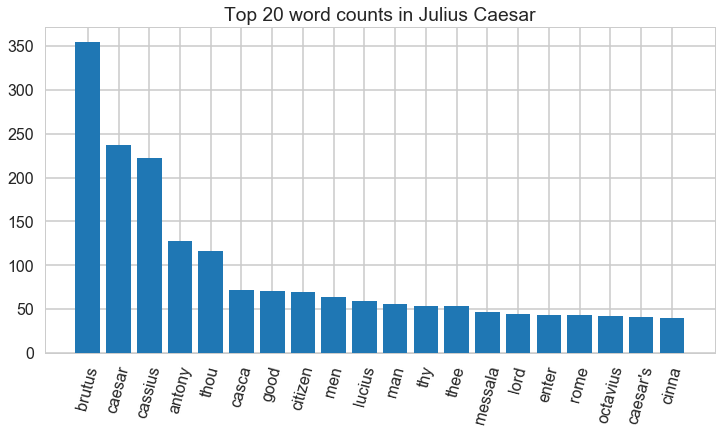

In [26]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.bar(range(len(top20_jc_words)), [e[1] for e in top20_jc_words], align='center')
plt.xticks(range(len(top20_jc_words)), [e[0] for e in top20_jc_words])
plt.xticks(rotation=75)
plt.title('Top 20 word counts in Julius Caesar');

## Scale MapReduce
The efficiency of MapReduce is that scaling an application to run over hundreds or thousands+ machines in a cluster involves a simple configuration change.

Spark will run one task for each partition of the cluster. For parallel collections the recommendation is 2-4 partitions for each CPU in the cluster which Spark tries to set automatically based on the cluster. The default for external data is one partition for each block (about 128MB) of the file, but there cannot be fewer partitions than blocks.

In order to use all of the available processing power, the number of partitions can be set manually by passing it as a second parameter to `parallelize()` or `textFile()`.

In [27]:
bard_rdd = sc.textFile('data/shakespeare/*.txt', 4)
type(bard_rdd)

pyspark.rdd.RDD

In [28]:
bard_words = bard_rdd.flatMap(lambda w: w.split(' ')) \
    .map(lambda w: re.sub(r"[^a-zA-Z']", '', w)) \
    .map(lambda w: w.lower()) \
    .filter(lambda w: w != '')
    
print('Number of words in 15 Shakespeare Plays:', len(bard_words.collect()))

Number of words in 15 Shakespeare Plays: 364505


In [29]:
bard_words.filter(lambda w: w not in stop_words).take(5)

['william', 'shakespeare', 'dramatis', 'personae', 'duke']

In [30]:
# MapReduce:
bard_word_counts = bard_words.filter(lambda w: w not in stop_words).map(lambda w: (w, 1)).reduceByKey(lambda x,y: x+y)

# Top 20 word counts:
top20_bard_words = bard_word_counts.takeOrdered(20, lambda e: -e[1])

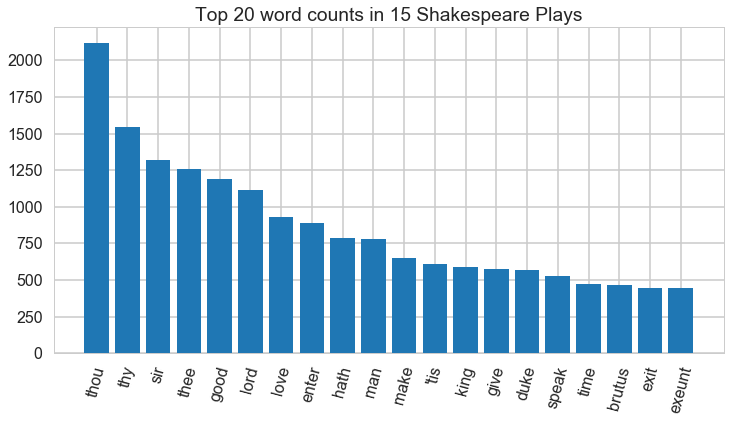

In [31]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.bar(range(len(top20_bard_words)), [e[1] for e in top20_bard_words], align='center')
plt.xticks(range(len(top20_bard_words)), [e[0] for e in top20_bard_words])
plt.xticks(rotation=75)
plt.title('Top 20 word counts in 15 Shakespeare Plays');

<a href='#top' id='df'>back to menu</a>

---
## SQL & SPARK DATAFRAMES
Determining the best optimization makes RDDs more complicated, but the Spark SQL module has structured data optimization built in, and it can process data via SQL or Spark DataFrame.

First, create a `SparkSession` object from the `SparkContext`. 

Whereas `SparkContext` is the connection to the cluster, the `SparkSession` is the interface with that connection. 

Best practice is to use the `SparkSession.builder.getOrCreate()` method which returns an existing session, or creates a new one if there's not one already in the environment.

In [32]:
from pyspark.sql import SparkSession

# Create spark session:
session = SparkSession.builder.getOrCreate()
session

## Create DataFrames and Register Tables
To create a Spark DataFrame on the SparkSession:
```python
sprk_df = session.read.csv('filepath/file.csv', header=True)
```

To run SQL queries over a dataframe, the table must be registered as a temporary view or persistent table.

```python
# Register dataframe as temporary view:
sprk_df.createOrReplaceTempView('table_name')

# Register dataframe as persistent table:
sprk_df.saveAsTable('table_name')
```

In [33]:
# data source: http://www.gunviolencearchive.org/

# Save file as a spark dataframe:
sprk_df_jan = session.read.csv('data/gun_violence/jan2018_sc.csv', header=True).drop(*['Address', 'Operations'])

# Register dataframe as SQL temporary table:
sprk_df_jan.createOrReplaceTempView('jan_2018')

# Print the tables in the catalog:
print(session.catalog.listTables())
print()

sprk_df_jan.show(5)

[Table(name='jan_2018', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]

+----------------+--------------+----------------+--------+---------+
|   Incident Date|         State|  City Or County|# Killed|# Injured|
+----------------+--------------+----------------+--------+---------+
|January 31, 2018|South Carolina|North Charleston|       0|        0|
|January 31, 2018|South Carolina|    Myrtle Beach|       0|        1|
|January 31, 2018|South Carolina|      Blacksburg|       0|        0|
|January 31, 2018|South Carolina|      Orangeburg|       0|        0|
|January 31, 2018|South Carolina|      Greenville|       1|        0|
+----------------+--------------+----------------+--------+---------+
only showing top 5 rows



In [34]:
type(sprk_df_jan)

pyspark.sql.dataframe.DataFrame

### Convert Pandas DataFrame to Spark DataFrame

In [35]:
# Save file as a pandas dataframe:
pd_df_feb = pd.read_csv('data/gun_violence/feb2018_sc.csv').drop(['Address', 'Operations'], axis=1)

print(type(pd_df_feb))
print()
pd_df_feb.head()

<class 'pandas.core.frame.DataFrame'>



,Incident Date,State,City Or County,# Killed,# Injured
0,"February 28, 2018",South Carolina,Inman,0,0
1,"February 28, 2018",South Carolina,Greenville,0,0
2,"February 28, 2018",South Carolina,North Charleston,0,1
3,"February 28, 2018",South Carolina,Greenwood,1,0
4,"February 27, 2018",South Carolina,Warrenville,0,0


In [36]:
sprk_df_feb = session.createDataFrame(pd_df_feb)

sprk_df_feb.createOrReplaceTempView('feb_2018')

print(type(sprk_df_feb))
print()
session.catalog.listTables()

<class 'pyspark.sql.dataframe.DataFrame'>



[Table(name='feb_2018', database=None, description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='jan_2018', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]

### Spark DataFrames are Immutable
The Spark DataFrame is immutable, so data cannot be updated in place. To overwrite the original DataFrame, reassign the returned DataFrame.

In [37]:
type(sprk_df_jan.State)

pyspark.sql.column.Column

In [38]:
sprk_df_jan = sprk_df_jan.withColumn('Casualties', sprk_df_jan['# Killed'] + sprk_df_jan['# Injured'])
sprk_df_jan.show(5)

+----------------+--------------+----------------+--------+---------+----------+
|   Incident Date|         State|  City Or County|# Killed|# Injured|Casualties|
+----------------+--------------+----------------+--------+---------+----------+
|January 31, 2018|South Carolina|North Charleston|       0|        0|       0.0|
|January 31, 2018|South Carolina|    Myrtle Beach|       0|        1|       1.0|
|January 31, 2018|South Carolina|      Blacksburg|       0|        0|       0.0|
|January 31, 2018|South Carolina|      Orangeburg|       0|        0|       0.0|
|January 31, 2018|South Carolina|      Greenville|       1|        0|       1.0|
+----------------+--------------+----------------+--------+---------+----------+
only showing top 5 rows



The column was added to the dataframe only, not the table view that was created earlier.

## SQL Queries
The DataFrame interface allows SQL queries on tables in the Spark cluster.

In [39]:
session.sql('FROM jan_2018 SELECT * LIMIT 5').show()

+----------------+--------------+----------------+--------+---------+
|   Incident Date|         State|  City Or County|# Killed|# Injured|
+----------------+--------------+----------------+--------+---------+
|January 31, 2018|South Carolina|North Charleston|       0|        0|
|January 31, 2018|South Carolina|    Myrtle Beach|       0|        1|
|January 31, 2018|South Carolina|      Blacksburg|       0|        0|
|January 31, 2018|South Carolina|      Orangeburg|       0|        0|
|January 31, 2018|South Carolina|      Greenville|       1|        0|
+----------------+--------------+----------------+--------+---------+



In [40]:
# Save file as a spark dataframe:
sprk_df_mar = session.read.csv('data/gun_violence/mar2018_sc.csv', header=True).drop(*['Address', 'Operations'])

# Register dataframe as SQL temporary table:
sprk_df_mar.createOrReplaceTempView('mar_2018')


session.catalog.listTables()

[Table(name='feb_2018', database=None, description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='jan_2018', database=None, description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='mar_2018', database=None, description=None, tableType='TEMPORARY', isTemporary=True)]

In [41]:
# Query mass shootings in January 2018:
query = 'FROM jan_2018 SELECT * WHERE `# Killed` + `# Injured` >= 4'
session.sql(query).show()

+----------------+--------------+--------------+--------+---------+
|   Incident Date|         State|City Or County|# Killed|# Injured|
+----------------+--------------+--------------+--------+---------+
|January 16, 2018|South Carolina|          York|       1|        4|
+----------------+--------------+--------------+--------+---------+



In [42]:
# Group and aggregate gun deaths by county in February 2018:
query = 'FROM feb_2018 SELECT `City Or County`, COUNT(`# Killed`) GROUP BY `City Or County`'
session.sql(query).show(10)

+--------------+---------------+
|City Or County|count(# Killed)|
+--------------+---------------+
|      Bluffton|              1|
|    Charleston|              4|
|    Georgetown|              2|
|         Lyman|              1|
|        Conway|              1|
|        Marion|              1|
|        Sumter|              2|
|         Lamar|              1|
|      Beaufort|              1|
|        Camden|              1|
+--------------+---------------+
only showing top 10 rows



### Convert Spark DataFrame to Pandas DataFrame
After running a query on a huge dataset and aggregating it down to something more manageable, it may make sense to work with it locally in pandas.

In [43]:
query = 'FROM mar_2018 SELECT `City Or County`, COUNT(`# Killed`) GROUP BY `City Or County`'
county_counts = session.sql(query)
pd_counts = county_counts.toPandas()
pd_counts.head(10)

,City Or County,count(# Killed)
0,Blythewood,2
1,Saint George,1
2,Charleston,3
3,Conway,2
4,Marion,1
5,Eutawville,1
6,Allendale,1
7,Adams Run,1
8,Beaufort,1
9,Latta,1


In [44]:
type(pd_counts)

pandas.core.frame.DataFrame

## DataFrame Operations

### Filter Data

In [45]:
# Filter mass shootings in SC for January 2018:
sprk_df_jan.filter(sprk_df_jan.Casualties >= 4).show()

+----------------+--------------+--------------+--------+---------+----------+
|   Incident Date|         State|City Or County|# Killed|# Injured|Casualties|
+----------------+--------------+--------------+--------+---------+----------+
|January 16, 2018|South Carolina|          York|       1|        4|       5.0|
+----------------+--------------+--------------+--------+---------+----------+



In [46]:
# Filter mass shootings in SC for February 2018:
sprk_df_feb.filter((sprk_df_feb['# Killed'] + sprk_df_feb['# Injured']) >= 4).show()

+-------------+-----+--------------+--------+---------+
|Incident Date|State|City Or County|# Killed|# Injured|
+-------------+-----+--------------+--------+---------+
+-------------+-----+--------------+--------+---------+



### Select Columns

In [47]:
casualties = sprk_df_jan.select('Incident Date', 'City Or County', 'Casualties')
casualties.show(5)

+----------------+----------------+----------+
|   Incident Date|  City Or County|Casualties|
+----------------+----------------+----------+
|January 31, 2018|North Charleston|       0.0|
|January 31, 2018|    Myrtle Beach|       1.0|
|January 31, 2018|      Blacksburg|       0.0|
|January 31, 2018|      Orangeburg|       0.0|
|January 31, 2018|      Greenville|       1.0|
+----------------+----------------+----------+
only showing top 5 rows



In [48]:
filter_1 = casualties['City Or County'] == 'North Charleston'
filter_2 = casualties.Casualties >= 1
casualties.filter(filter_1).filter(filter_2).show()

+----------------+----------------+----------+
|   Incident Date|  City Or County|Casualties|
+----------------+----------------+----------+
|January 28, 2018|North Charleston|       1.0|
|January 17, 2018|North Charleston|       1.0|
| January 3, 2018|North Charleston|       1.0|
+----------------+----------------+----------+



In [49]:
casualties = (sprk_df_feb['# Killed'] + sprk_df_feb['# Injured']).alias('Casualties')
sprk_df_feb.select('Incident Date', 'City Or County', casualties).show(5)

+-----------------+----------------+----------+
|    Incident Date|  City Or County|Casualties|
+-----------------+----------------+----------+
|February 28, 2018|           Inman|         0|
|February 28, 2018|      Greenville|         0|
|February 28, 2018|North Charleston|         1|
|February 28, 2018|       Greenwood|         1|
|February 27, 2018|     Warrenville|         0|
+-----------------+----------------+----------+
only showing top 5 rows



In [50]:
sprk_df_feb.selectExpr('`Incident Date`', '`City Or County`', '`# Killed` + `# Injured` as Casualties').show(5)

+-----------------+----------------+----------+
|    Incident Date|  City Or County|Casualties|
+-----------------+----------------+----------+
|February 28, 2018|           Inman|         0|
|February 28, 2018|      Greenville|         0|
|February 28, 2018|North Charleston|         1|
|February 28, 2018|       Greenwood|         1|
|February 27, 2018|     Warrenville|         0|
+-----------------+----------------+----------+
only showing top 5 rows



### Group and Aggregate

In [51]:
sprk_df_jan.groupBy().max('Casualties').show()

+---------------+
|max(Casualties)|
+---------------+
|            5.0|
+---------------+



In [52]:
sprk_df_jan.groupBy().avg('Casualties').show()

+---------------+
|avg(Casualties)|
+---------------+
|        0.71875|
+---------------+



In [53]:
# FROM jan2017_sc SELECT `City Or County`, COUNT(`# Killed`) GROUP BY `City Or County`
sprk_df_jan.groupBy('City Or County').sum().show()

+------------------+---------------+
|    City Or County|sum(Casualties)|
+------------------+---------------+
|          Bluffton|            0.0|
|        Charleston|            6.0|
|        Georgetown|            1.0|
|             Lyman|            1.0|
|            Conway|            1.0|
|            Marion|            4.0|
|      Beech Island|            0.0|
|            Sumter|            1.0|
|             Lamar|            0.0|
|          Beaufort|            2.0|
|         Pendleton|            4.0|
|         Fort Mill|            1.0|
|          Woodruff|            1.0|
|          Florence|            2.0|
|           Mc Coll|            1.0|
|             Inman|            0.0|
|             Aiken|            4.0|
|      Simpsonville|            2.0|
|Hilton Head Island|            1.0|
|             Loris|            2.0|
+------------------+---------------+
only showing top 20 rows



### Join DataFrames

In [54]:
sprk_df_mar_ga = session.read.csv('data/gun_violence/mar2018_ga.csv', header=True).drop(*['Address', 'Operations'])
sprk_df_mar_ga.show(5)

+--------------+-------+------------------+--------+---------+
| Incident Date|  State|    City Or County|# Killed|# Injured|
+--------------+-------+------------------+--------+---------+
|March 31, 2018|Georgia|Chattooga (county)|       0|        1|
|March 31, 2018|Georgia|              Lula|       0|        0|
|March 31, 2018|Georgia|         Hephzibah|       0|        1|
|March 31, 2018|Georgia|           Atlanta|       1|        0|
|March 31, 2018|Georgia|            Athens|       0|        0|
+--------------+-------+------------------+--------+---------+
only showing top 5 rows



In [55]:
sprk_df_mar.join(sprk_df_mar_ga, on='Incident Date').show(5)

+--------------+--------------+--------------+--------+---------+-------+------------------+--------+---------+
| Incident Date|         State|City Or County|# Killed|# Injured|  State|    City Or County|# Killed|# Injured|
+--------------+--------------+--------------+--------+---------+-------+------------------+--------+---------+
|March 31, 2018|South Carolina|         Loris|       0|        1|Georgia|Chattooga (county)|       0|        1|
|March 31, 2018|South Carolina| Bennettsville|       0|        0|Georgia|Chattooga (county)|       0|        1|
|March 31, 2018|South Carolina|     Rock Hill|       1|        0|Georgia|Chattooga (county)|       0|        1|
|March 31, 2018|South Carolina|         Loris|       0|        1|Georgia|              Lula|       0|        0|
|March 31, 2018|South Carolina| Bennettsville|       0|        0|Georgia|              Lula|       0|        0|
+--------------+--------------+--------------+--------+---------+-------+------------------+--------+---

<a href='#top' id='log'>back to menu</a>

---
## LOGISTIC REGRESSION WITH SPARK



In [56]:
df = session.read.csv('data/heights_weights_genders.csv', header=True)
df.show(5)

+------+----------------+----------------+
|Gender|          Height|          Weight|
+------+----------------+----------------+
|  Male| 73.847017017515|241.893563180437|
|  Male|68.7819040458903|162.310472521300|
|  Male|74.1101053917849|  212.7408555565|
|  Male|71.7309784033377|220.042470303077|
|  Male|69.8817958611153|206.349800623871|
+------+----------------+----------------+
only showing top 5 rows



In [57]:
df.dtypes

[('Gender', 'string'), ('Height', 'string'), ('Weight', 'string')]

Spark only handles numeric data, so the columns need to be converted appropriately.

In [58]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

df = df.withColumn('Height', df.Height.cast('double'))
df = df.withColumn('Weight', df.Weight.cast('double'))

# Create a StringIndexer:
gender_indexer = StringIndexer(inputCol='Gender', outputCol='label')

# Make a VectorAssembler for features:
features = VectorAssembler(inputCols=['Height', 'Weight'], outputCol='features')

pipeline = Pipeline(stages=[gender_indexer, features])
transformed = pipeline.fit(df).transform(df)
transformed

DataFrame[Gender: string, Height: double, Weight: double, label: double, features: vector]

In [59]:
transformed.show(5)

+------+----------------+----------------+-----+--------------------+
|Gender|          Height|          Weight|label|            features|
+------+----------------+----------------+-----+--------------------+
|  Male| 73.847017017515|241.893563180437|  0.0|[73.847017017515,...|
|  Male|68.7819040458903|  162.3104725213|  0.0|[68.7819040458903...|
|  Male|74.1101053917849|  212.7408555565|  0.0|[74.1101053917849...|
|  Male|71.7309784033377|220.042470303077|  0.0|[71.7309784033377...|
|  Male|69.8817958611153|206.349800623871|  0.0|[69.8817958611153...|
+------+----------------+----------------+-----+--------------------+
only showing top 5 rows



In [60]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import pyspark.ml.evaluation as evals

train, test = transformed.randomSplit([0.8, 0.2])
lr = LogisticRegression()

# Create ParamMaps for Cross Validation:
grid = (ParamGridBuilder().addGrid(lr.regParam, np.arange(0, 0.1, 0.01)).build())

# Create model evaluator:
evaluator = evals.BinaryClassificationEvaluator(metricName='areaUnderROC')

# Create 10-fold CrossValidator:
cv = CrossValidator(
    estimator=lr, 
    estimatorParamMaps=grid, 
    evaluator=evaluator, 
    numFolds=10
)

# Cross-validate to find best parameters:
models = cv.fit(train)
best = models.bestModel

# Predict on test set with best model:
predictions = best.transform(test)
print('AUC:', evaluator.evaluate(predictions))

AUC: 0.9631550574549457


In [61]:
weights = best.coefficients
weights = [(float(w),) for w in weights]

print('Feature Weights:')
weights

Feature Weights:


[(0.49681707035598804,), (-0.20437605039787454,)]

<a href='#top' id='lin'>back to menu</a>

---
## LINEAR REGRESSION WITH SPARK

<a href='#top'>back to menu</a>

In [62]:
sc.stop()